# Importing Libraries

In [1]:
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

simulator = Aer.get_backend('qasm_simulator')

from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')

from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

# For Error Mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# For Noise Simulations
from qiskit.test.mock import FakeMelbourne
fake_device = FakeMelbourne()

from qiskit.providers.aer.noise import NoiseModel

# Metric

In [2]:
def metrics(counts, c1a, c1b, c2a, c2b, ra, rb):
    success, fail = 0, 0
    phi_plus, psi_plus, phi_minus, psi_minus = 0, 0, 0, 0 

    for result in counts:
        if (result[c1a]==result[c1b] and result[c2a]==result[c2b]):
            success += counts[result]

            if (result[ra]=='0' and result[rb]=='0'): 
                phi_plus += counts[result]
            elif (result[ra]=='0' and result[rb]=='1'): 
                psi_plus += counts[result]
            elif (result[ra]=='1' and result[rb]=='0'): 
                phi_minus += counts[result]
            elif (result[ra]=='1' and result[rb]=='1'): 
                psi_minus += counts[result]
        else:
            fail += counts[result]

    total = success + fail
    print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
    yields = success/(total)
    print('yield:', yields, '\n')

    print('Among success, phi+:', phi_plus, ',', 'psi+:', psi_plus, ',', 'phi-:', phi_minus, ',', 'psi-:', psi_minus)
    fidelity = phi_plus/success
    print('fidelity', fidelity)

# Create sub-circuit for Entanglement-Swapping

In [2]:
sub_q = QuantumRegister(3)
sub_circ = QuantumCircuit(sub_q, name='en\nsw')

sub_circ.cx(sub_q[0], sub_q[1])
sub_circ.h(sub_q[0])
sub_circ.cx(sub_q[1], sub_q[2])
sub_circ.cz(sub_q[0], sub_q[2])

ent_swap = sub_circ.to_instruction()

# Building Quantum-Repeater Circuit

MemoryError: In RendererAgg: Out of memory

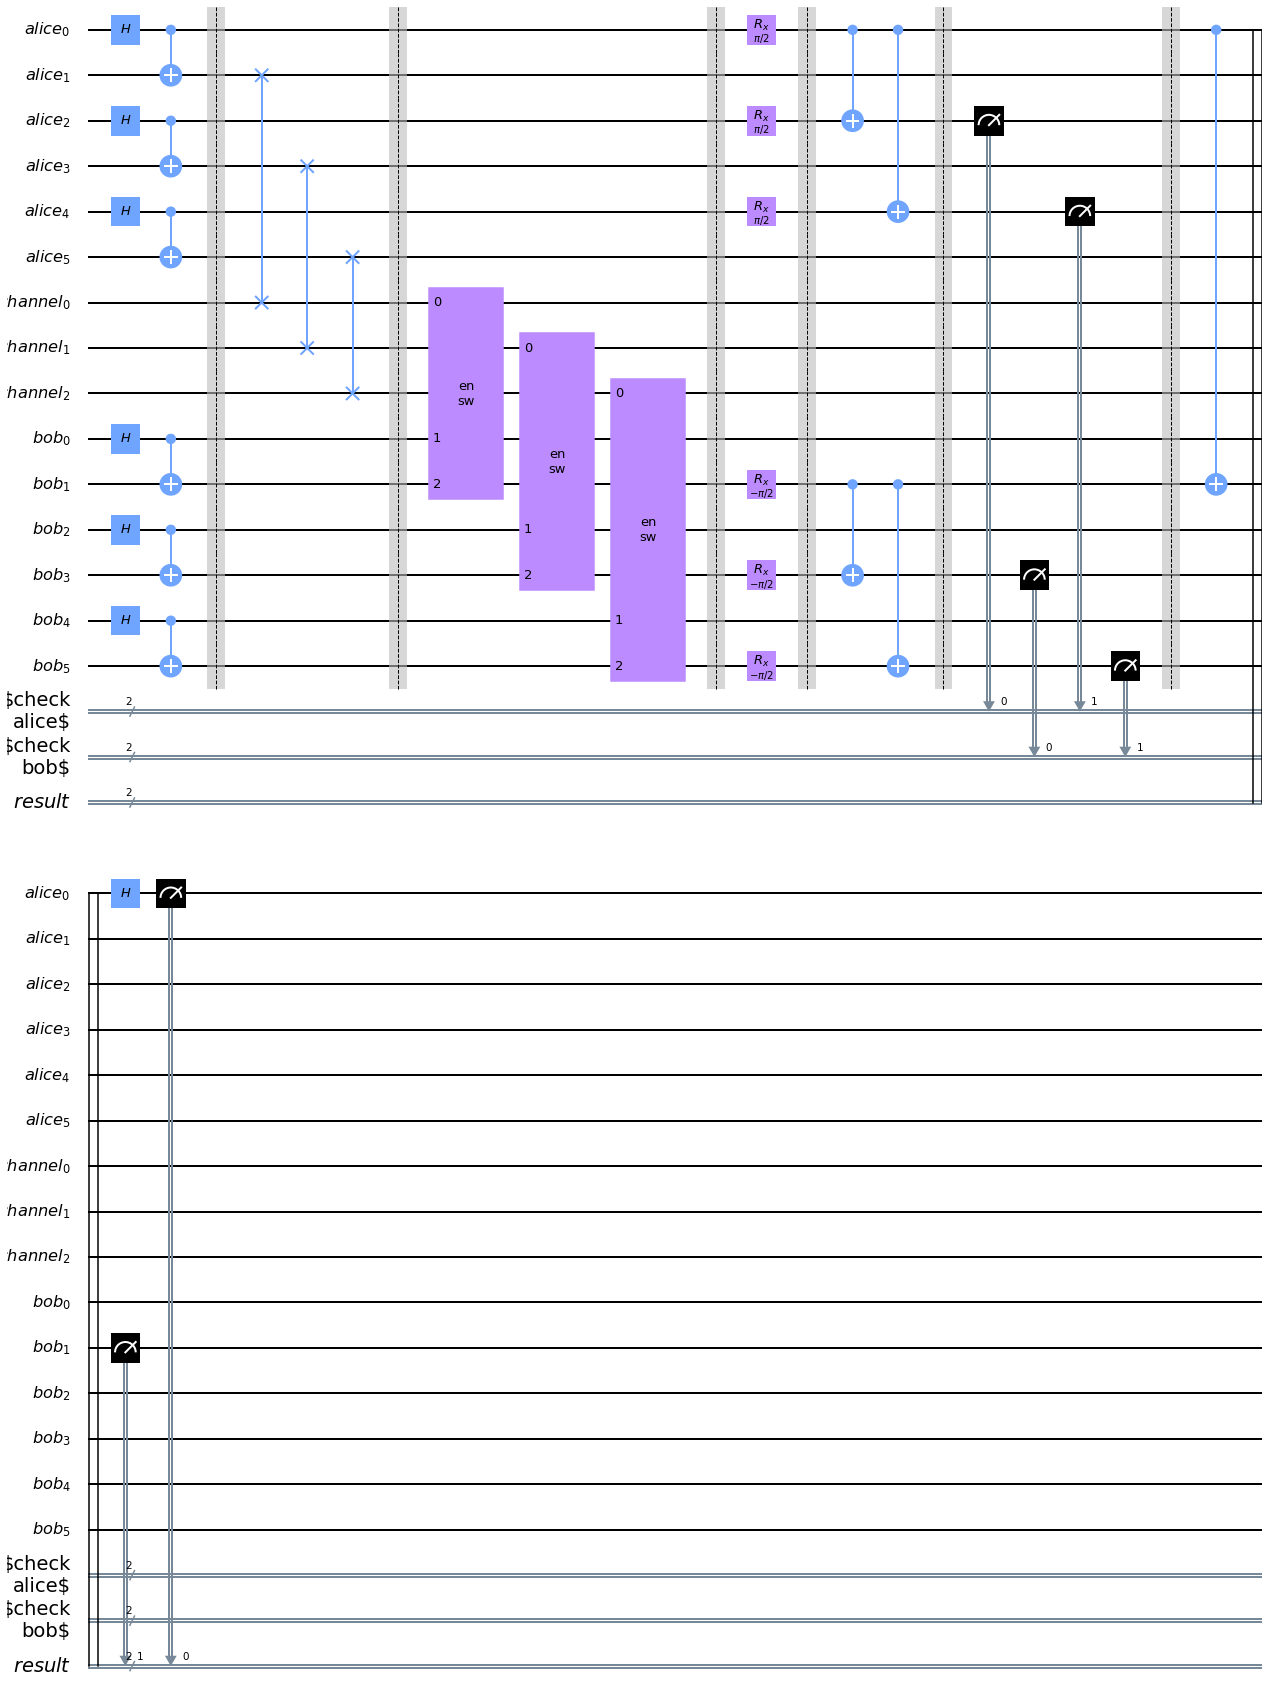

In [16]:
# no. of correction qubits
n = 3

# preparing registers
alice = QuantumRegister(2*n, 'alice')
bob = QuantumRegister(2*n, 'bob')
channel = QuantumRegister(n, 'channel')
check_alice = ClassicalRegister(n-1, 'check\nalice')
check_bob = ClassicalRegister(n-1, 'check\nbob')
result = ClassicalRegister(2, 'result')

# constructing circuit

sys = QuantumCircuit(alice, channel, bob, check_alice, check_bob, result)

# creating bell-pairs

for i in range(0, 2*n, 2):
    sys.h(alice[i])
    sys.cx(alice[i], alice[i+1])
    
    sys.h(bob[i])
    sys.cx(bob[i], bob[i+1])

sys.barrier()

# transferring qubits to quantum channel

for i in range (0, n):
    sys.swap(alice[2*i+1], channel[i])

sys.barrier()

# entanglement swapping
for i in range(0, n):
    sys.append(ent_swap, [channel[i], bob[2*i], bob[2*i+1]])

sys.barrier()

#Deutsch's Correction 

#rotation-Alice
for i in range(0, n):
    sys.rx(pi/2, alice[2*i])
    sys.rx(-pi/2, bob[2*i+1])
    
sys.barrier()

# bennett's protocol
for i in range(2, 2*n, 2):
    sys.cx(alice[0], alice[i])
    sys.cx(bob[1], bob[i+1])
    
sys.barrier()

# distillation
# sys.measure([alice[2], alice[4]], [check_alice[0], check_alice[1]])
# sys.measure([bob[3], bob[5]], [check_bob[0], check_bob[1]])
for i in range(1, n):
    sys.measure(alice[2*i], check_alice[i-1])
    sys.measure(bob[2*i+1], check_bob[i-1])

sys.barrier()

#checking final fidelity through bell-measurement
sys.cx(alice[0], bob[1])
sys.h(alice[0])

sys.measure([alice[0], bob[1]], [result[0], result[1]])

path = 'C:/Users/sdas_/Desktop/Quantum Computing Thesis/paper-figures/new pictures/'
style = {'cregbundle': True, 'dpi': 1600, 'margin':[0.66,0,0,0], 'fontsize':13, 'subfontsize':10}
sys.draw(output='mpl', style=style, plot_barriers=True, initial_state=True, with_layout=True, scale=0.7, filename=path+'circ_repeater.png')

#sys.draw(output='mpl')

# Running on Real Device

In [ ]:
from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_16_melbourne')

In [ ]:
from qiskit import execute
from qiskit.tools.monitor import job_monitor

In [ ]:
shots = 8192
job = execute(sys, backend=simulator, shots=shots)

print(job.job_id())
job_monitor(job)

In [ ]:
device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)

# Noisy Simulation

In [5]:
noise_model = NoiseModel.from_backend(fake_device)
coupling_map = fake_device.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [6]:
shots = 8192
noise_job = execute(sys, simulator, shots=shots,
                       noise_model=noise_model,
                       #coupling_map=coupling_map,
                       basis_gates=basis_gates)

print(noise_job.job_id())
job_monitor(noise_job)

f72c291f-5366-4299-ad7a-4287064e464e
Job Status: job has successfully run


In [7]:
noise_result = noise_job.result()
noise_counts = noise_result.get_counts()

print(noise_counts)

metrics(noise_counts, 3,6, 4,7, 1,0)

{'00 00 11': 20, '00 00 00': 1115, '10 11 00': 52, '11 01 00': 14, '01 10 11': 123, '00 00 01': 208, '10 10 01': 58, '01 01 00': 131, '00 10 00': 100, '10 11 11': 63, '10 10 00': 15, '11 01 01': 10, '11 00 10': 20, '10 11 01': 18, '01 00 10': 28, '00 11 10': 210, '01 11 11': 216, '10 01 00': 22, '10 10 11': 17, '01 01 10': 15, '00 01 11': 81, '01 01 01': 221, '00 11 11': 1096, '01 11 10': 94, '01 10 01': 11, '11 10 10': 22, '11 11 01': 12, '11 11 11': 22, '00 10 11': 172, '00 11 01': 79, '00 10 01': 19, '01 10 10': 231, '10 00 00': 70, '11 11 10': 14, '01 00 00': 233, '10 01 11': 17, '11 10 11': 14, '00 10 10': 1054, '01 01 11': 39, '00 01 00': 187, '10 11 10': 19, '10 00 11': 54, '11 00 00': 17, '01 00 11': 13, '11 00 11': 73, '10 10 10': 78, '00 11 00': 19, '01 11 01': 35, '11 10 01': 56, '01 10 00': 43, '11 11 00': 64, '10 01 01': 76, '01 00 01': 113, '11 10 00': 14, '01 11 00': 17, '10 00 10': 23, '11 01 11': 19, '10 00 01': 15, '00 01 01': 1070, '11 00 01': 12, '00 01 10': 8, '11 